In [137]:
using DelimitedFiles
using StatsBase
using HDF5
using Plots; gr();

In [4]:
ign, h = readdlm("data/remote/base_nobin/bsr_ignmajors_1.csv", ',', header=true);

In [20]:
sio2 = ign[:,2];

In [14]:
indices = Int.(ign[:,1]);

In [22]:
s = sample(indices,3,replace=false)

3-element Array{Int64,1}:
 84748
 22246
 33929

In [58]:
target = [66.6, 63.5, 53.4]
n = 100
samples = zeros(Int, (3,n))
for l in 1:3
    s = sample(indices,n, replace=false)
    snew = zeros(Int, length(s))
    snew .= s
    best = abs(mean(sio2[s]) - target[l])
    while best > 1/20
        to_replace = sample(1:n)
        new = sample(indices)
        snew[to_replace] = new
        if abs(mean(sio2[snew]) - target[l]) < best
            s .= snew
            best = abs(mean(sio2[snew]) - target[l])
            #println("new best $(mean(sio2[snew]))")
        end
        snew .= s # reset
    end
    samples[l,:] .= s
end 

In [60]:
for l in 1:3
    println(mean(sio2[samples[l,:]]))
end
println(target)

66.5938866
63.5182639
53.408159000000005
[66.6, 63.5, 53.4]


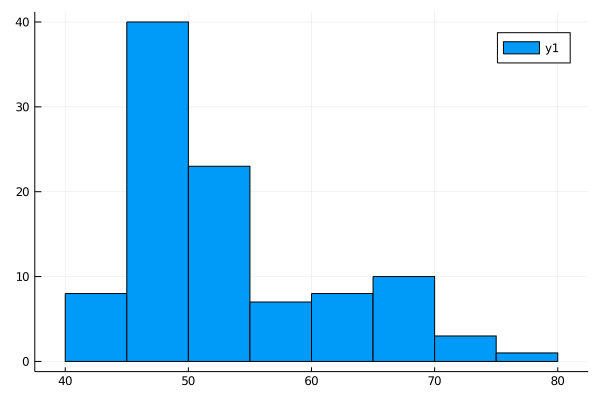

In [57]:
histogram(sio2[samples[3,:]])

In [76]:
include("src/crustDistribution.jl")

Loading crust information from file data/crustDistribution.jld


┌ Warning: JLD incorrectly extends FileIO functions (see FileIO documentation)
└ @ FileIO /Users/gailin/.julia/packages/FileIO/AmppF/src/loadsave.jl:210


Main.crustDistribution

In [126]:
include("src/config.jl")
include("src/parsePerplex.jl")
include("src/seismic.jl")
include("src/cracks.jl")

mu_from_poissons (generic function with 1 method)

In [161]:
include("src/invertData.jl")

getAllSeismic

In [133]:
(rho_c, vp_c, vpvs_c, geotherm) = getPerplexTestSeismic(200, 6, nsamples=20)

Building fake earth100%|████████████████████████████████| Time: 0:01:18


([2855.5014958159013, 2818.9559897808454, 2661.087540674652, 2856.152208699943, 2842.4989733744515, 2642.640661272292, 2571.590030348222, 2650.1077479596365, 2571.838201982075, 2648.910236133259  …  2822.692988489154, 2857.627478911255, 2654.6293856906705, 2692.6764717112937, 2538.9054092219358, 2545.9111822259506, 2570.0127081752526, 2749.3028718869327, 2570.038008824895, 2567.515951805037], [6.46011245552156, 6.239481040994932, 6.122782285791358, 6.46583546455615, 6.3995201591037665, 6.116959926972601, 6.159874819825983, 6.148480192794691, 6.157768235024649, 6.071735161415932  …  6.252539782237402, 6.472070540095417, 6.096110978915393, 6.14027525188778, 5.842251721248062, 5.855250817853771, 6.150113841350604, 6.36922425865001, 6.149375774068068, 6.135809132557407], [1.7602342950326622, 1.7034127056990076, 1.6779655868571228, 1.7576976875713435, 1.7716557369157349, 1.665398511264565, 1.6651275082116685, 1.6653393448925626, 1.6667904160987197, 1.6777661940779214  …  1.7036167685482022,

In [125]:
vp[vp .!= 0 ]

200-element Array{Float64,1}:
 6.108875458615293 
 6.162472211772879 
 6.140408647919409 
 6.215205960782187 
 6.104114722783096 
 6.13391712907787  
 6.139278819181953 
 6.307949459426777 
 6.119159451828468 
 6.123353374346005 
 6.243518337210604 
 5.493286375982216 
 6.116034645885067 
 ⋮                 
 5.995076284723577 
 6.067668974655563 
 5.466829298285775 
 6.318187482885996 
 6.1231986475089535
 6.235118380828192 
 6.11775392660888  
 6.111588741982891 
 6.233589087292647 
 6.242835835641936 
 5.515097366669259 
 6.3267326679206155

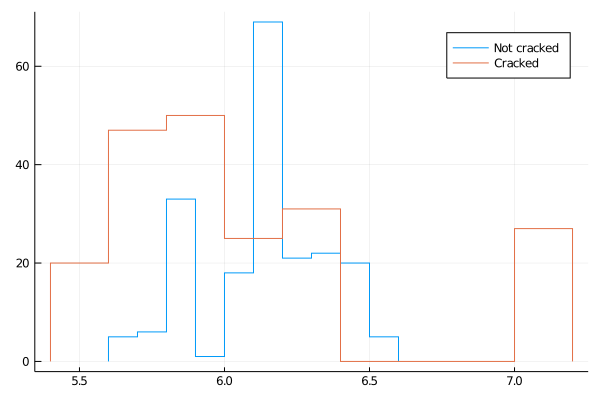

In [134]:
stephist(vp_c, label="Not cracked")
stephist!(vp_noc, label="Cracked")

In [246]:
ign,h = readdlm("data/remote/base/bsr_ignmajors_2.csv", ',', header=true);
seismic = h5read("data/remote/base/perplex_out_2.h5", "results");

In [178]:
f = isnan.(sum(seismic[:,3,:], dims=1))[:];
sum(failed)

321.77899

In [179]:
mean(ign[f,2])

64.77914166850829

In [180]:
mean(ign[.!f,2])

58.62339997981735

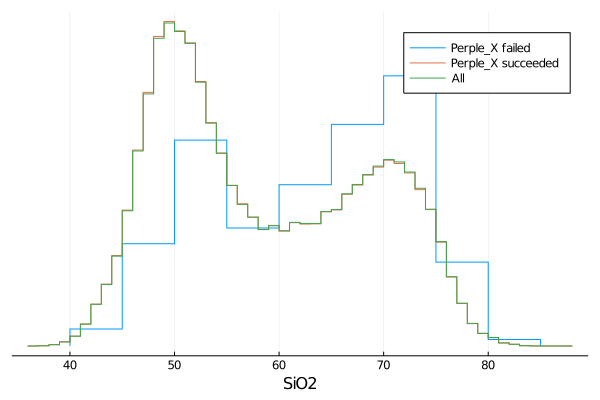

In [247]:
stephist(ign[f,2], label= "Perple_X failed", normalize=:pdf)
stephist!(ign[.!f,2], label="Perple_X succeeded", normalize=:pdf)
stephist!(ign[:,2], label="All", normalize=:pdf, yaxis=false, yticks=false, xlabel="SiO2")
#savefig("../present/perplex_prior.png")

In [159]:
(rho_c, vp_c, vpvs_c, geotherm) = getPerplexTestSeismic(300, 6, nsamples=100)

Building fake earth 12%|███▉                            |  ETA: 0:05:38



Cannot process sample due to 
 ParsePerplexError("Endmembers do not sum to 1")
failed sample had 71.35683 % sio2


Building fake earth 37%|███████████▉                    |  ETA: 0:04:06



Cannot process sample due to 
 ParsePerplexError("Endmembers do not sum to 1")
failed sample had 47.7182 % sio2


Building fake earth 43%|█████████████▊                  |  ETA: 0:03:44



Cannot process sample due to 
 ParsePerplexError("Endmembers do not sum to 1")
failed sample had 78.63651 % sio2


Building fake earth 48%|███████████████▍                |  ETA: 0:03:24



Cannot process sample due to 
 ParsePerplexError("Endmembers do not sum to 1")
failed sample had 71.79254 % sio2


Building fake earth 56%|█████████████████▉              |  ETA: 0:02:55



Cannot process sample due to 
 ParsePerplexError("Endmembers do not sum to 1")
failed sample had 67.64883 % sio2


Building fake earth 73%|███████████████████████▍        |  ETA: 0:01:47



Cannot process sample due to 
 ParsePerplexError("Endmembers do not sum to 1")
failed sample had 73.20645 % sio2


Building fake earth 87%|███████████████████████████▉    |  ETA: 0:00:52



Cannot process sample due to 
 ArgumentError("cannot parse \"-76.81 -15.6713\" as Float64")
failed sample had 64.19476 % sio2


Building fake earth100%|████████████████████████████████| Time: 0:06:40


layer 1 has 100000 failed samples, mean sio2 0.00905


([2666.610749870401, 2607.9404442427603, 2585.3947447787154, 2629.696175215205, 3281.547182992739, 2656.4252153507327, 2614.5107554346064, 2642.7549916023027, 2717.6916902800776, 2717.47047476254  …  2567.446302157013, 2939.6521301826892, 2625.197089498917, 2645.1832003430372, 2619.4089175322174, 2709.6556113677243, 2617.6955372485086, 2640.497042405684, 2814.065725408485, 2799.3783214988916], [6.313919454862607, 5.983735631160196, 5.855471964926809, 6.34586440650694, 7.554881889710479, 6.249219485934911, 5.820689713455626, 6.221083676222452, 6.30309685675154, 6.301313599208761  …  5.819328788674276, 6.2180463532377654, 5.863083466531802, 6.431706138665743, 5.977840220566365, 6.3443767446747765, 5.97386339453464, 6.406311450741865, 6.013407794976585, 6.459632203919829], [1.7682086849510867, 1.5375905284653457, 1.5337025974729481, 1.6494762134372216, 1.7452384628383404, 1.7768538424923874, 1.5944360485167337, 1.6447169345719292, 1.6545639830640528, 1.6547433399319307  …  1.5445429016969

In [203]:
include("src/invertData.jl")

getAllSeismic

In [221]:
(rho_c, vp_c, vpvs_c, geotherm), indices = getPerplexTestSeismic(300, 6, nsamples=100)

Building fake earth  5%|█▋                              |  ETA: 0:06:06



Cannot process sample due to 
 ArgumentError("cannot parse \"-86.89 399.8222\" as Float64")
failed sample had 62.64227 % sio2


Building fake earth 13%|████▏                           |  ETA: 0:05:35



Cannot process sample due to 
 ParsePerplexError("Endmembers do not sum to 1")
failed sample had 71.29341 % sio2


Building fake earth 48%|███████████████▍                |  ETA: 0:03:28



Cannot process sample due to 
 ParsePerplexError("Endmembers do not sum to 1")
failed sample had 68.38233 % sio2


Building fake earth 81%|█████████████████████████▉      |  ETA: 0:01:16



Cannot process sample due to 
 ParsePerplexError("Endmembers do not sum to 1")
failed sample had 52.28337 % sio2


Building fake earth 87%|███████████████████████████▉    |  ETA: 0:00:52



Cannot process sample due to 
 ArgumentError("cannot parse \"-87.11 -23.9446\" as Float64")
failed sample had 66.63344 % sio2


Building fake earth100%|████████████████████████████████| Time: 0:06:44


layer 1 has 5 failed samples, mean sio2 64.24696399999999


(([2650.9729767527706, 2717.107687734813, 2512.776078241878, 2680.7134017804583, 2747.578458130271, 2797.0533892362764, 2756.5197896177838, 2656.268238204625, 2777.1019909824577, 2525.3738771622293  …  2568.19649639991, 3114.815071360341, 3103.04629691662, 3355.809960004539, 2685.5376737854635, 2718.2516023412154, 2720.614585974938, 2613.8076317216633, 2846.3927707041207, 2745.549270739824], [5.72173607823196, 6.1920525651959, 5.397529862700976, 5.418712014943795, 6.435842195735368, 6.229267580189721, 5.692461518338837, 5.732866569973642, 5.509648333719143, 5.713290605486562  …  5.613814846865509, 6.624249015966114, 6.5731900125710165, 7.245891196924116, 5.7069842276433675, 5.797282052855567, 6.038177427746804, 6.0771034124436945, 6.381091859038385, 5.979052583032409], [1.5471422146378204, 1.6639407082519193, 1.4313412198177369, 1.472760877920416, 1.6679078913931473, 1.5614994668457518, 1.6379355182578066, 1.546638014402553, 1.5442800485641828, 1.5013962846750075  …  1.5137646022702893

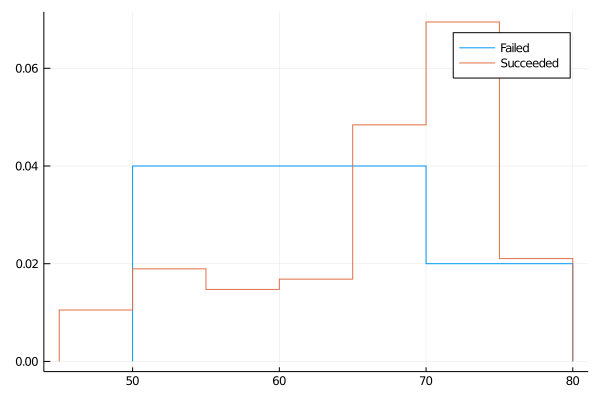

In [185]:
stephist(failed, normalize=:pdf, label="Failed")
stephist!(succeeded, normalize=:pdf, label="Succeeded")

In [205]:
indices

10-element Array{Int64,1}:
  2342
  7085
 80210
 16599
   959
 32345
 87243
 67595
 42905
 86529

In [209]:
ign[ign[:,1] .== indices[1],2:11]

1×10 Array{Float64,2}:
 57.1844  1.21905  14.9419  5.82474  …  3.66622  1.83109  1.4642  0.66084

In [248]:
ers = zeros((length(indices), 3))
for i in 1:length(indices)
    ers[i,:] .= seismic[2:4,1,indices[i]] .- [rho_c[i], vp_c[i], vpvs_c[i]]
end

In [249]:
nanmean(ers, dims=1)

1×3 Array{Float64,2}:
 135.892  0.28113  0.00120065

In [250]:
nanstd(ers, dims=1)

1×3 Array{Float64,2}:
 408.294  0.899493  0.1052

In [252]:
bins = collect(crustDistribution.binBoundaries(10))
gbins = zeros(length(geotherm))
for (i,g) in enumerate(geotherm)
    gbins[i] = searchsortedlast(bins,g)
end

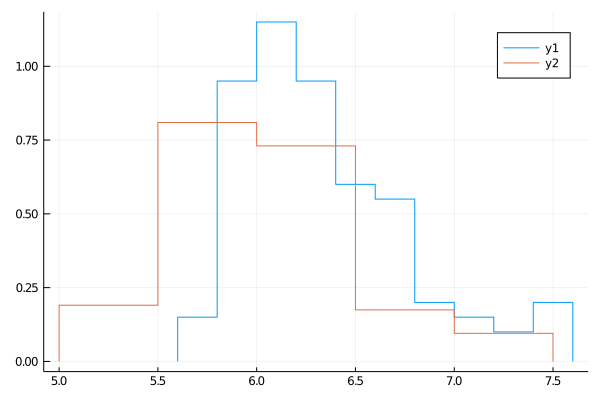

In [253]:
stephist(seismic[3,1,indices], normalize=:pdf)
stephist!(vp_c[gbins .== 2], normalize=:pdf)

In [241]:
bins = collect(crustDistribution.binBoundaries(10))

11-element Array{Float64,1}:
  22.0
  30.7
  39.4
  48.1
  56.8
  65.5
  74.2
  82.9
  91.6
 100.3
 109.0

In [243]:
bins = collect(crustDistribution.binBoundaries(10))
gbins = zeros(length(geotherm))
for (i,g) in enumerate(geotherm)
    gbins[i] = searchsortedlast(bins,g)
end

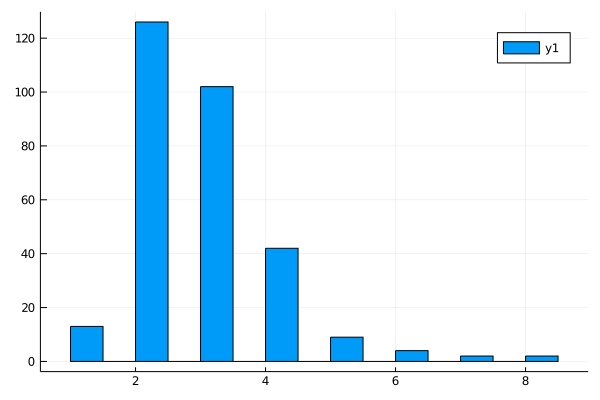

In [244]:
histogram(gbins)

In [254]:
using MAT

In [256]:
bulk = matread("data/bulk_err.mat")

Dict{String,Any} with 209 entries:
  "Pb206_Pb208"          => [NaN; NaN; … ; NaN; NaN]
  "Pd"                   => [NaN; NaN; … ; NaN; NaN]
  "MgO"                  => [NaN; NaN; … ; NaN; NaN]
  "Ag"                   => [NaN; NaN; … ; NaN; NaN]
  "Gd"                   => [NaN; NaN; … ; NaN; NaN]
  "Pb208_Pb206"          => [NaN; NaN; … ; NaN; NaN]
  "Th230_Activity"       => [NaN; NaN; … ; NaN; NaN]
  "Cl36_Cl"              => [NaN; NaN; … ; NaN; NaN]
  "Ra228_Ra226_Activity" => [NaN; NaN; … ; NaN; NaN]
  "Cs"                   => [NaN; NaN; … ; NaN; NaN]
  "Xe136_Xe130"          => [NaN; NaN; … ; NaN; NaN]
  "Ta"                   => [0.11; 0.1; … ; NaN; NaN]
  "Te"                   => [NaN; NaN; … ; NaN; NaN]
  "Xe136_Xe132"          => [NaN; NaN; … ; NaN; NaN]
  "Al2O3"                => [NaN; NaN; … ; NaN; NaN]
  "Loi"                  => [NaN; NaN; … ; NaN; NaN]
  "Fe2O3"                => [NaN; NaN; … ; NaN; NaN]
  "Ra228_Th232_Activity" => [NaN; NaN; … ; NaN; NaN]
  "K"     

In [260]:
bulk["err2srel"]

Dict{String,Any} with 127 entries:
  "Lower_Vp"         => 0.01
  "Pd"               => 0.02
  "MgO"              => 0.01
  "C"                => 0.02
  "Nb"               => 0.02
  "Ag"               => 0.02
  "Gd"               => 0.01
  "Middle_Rho"       => 0.008
  "Age"              => 0.0
  "Calc_Upper_VpVs"  => [0.174243; 0.154844; … ; 0.132003; NaN]
  "Sb"               => 0.02
  "TiO2"             => 0.01
  "Cs"               => 0.02
  "Be"               => 0.02
  "Sr"               => 0.02
  "Ta"               => 0.02
  "Ga"               => 0.02
  "Te"               => 0.02
  "Eustar"           => 0.1
  "Al2O3"            => 0.01
  "CO2"              => 0.02
  "Freeair"          => 0.0005
  "Y"                => 0.01
  "Calc_Middle_VpVs" => [0.00533703; 0.0438267; … ; NaN; NaN]
  "U"                => 0.02
  ⋮                  => ⋮